In [2]:
# !pip install -q git+https://github.com/openai/CLIP.git
!pip install -q ultralytics

In [3]:
import torch
import clip
import cv2
from PIL import Image
from torchvision import transforms

In [4]:
class GenderClassifierCLIP:
    def __init__(self, device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        self.text_inputs = clip.tokenize(["man", "woman"]).to(self.device)

    def preprocess_faces(self, faces):
        tensors = []
        for face in faces:
            if face is None or face.size == 0:
                continue
            pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
            tensors.append(self.preprocess(pil))
        if not tensors:
            return None
        return torch.stack(tensors).to(self.device)

    def predict(self, faces):
        face_tensor = self.preprocess_faces(faces)
        if face_tensor is None:
            return []

        with torch.no_grad():
            image_features = self.model.encode_image(face_tensor)
            text_features = self.model.encode_text(self.text_inputs)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            labels = ["Man" if sim[0] > sim[1] else "Woman" for sim in similarities]
            return labels


In [5]:
import cv2
faces = [cv2.imread("man.png"), cv2.imread("woman.png")]

classifier = GenderClassifierCLIP()
labels = classifier.predict(faces)

print(labels)  # ['Man', 'Woman']


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 53.6MiB/s]


['Man', 'Man']


In [18]:
import matplotlib.pyplot as plt

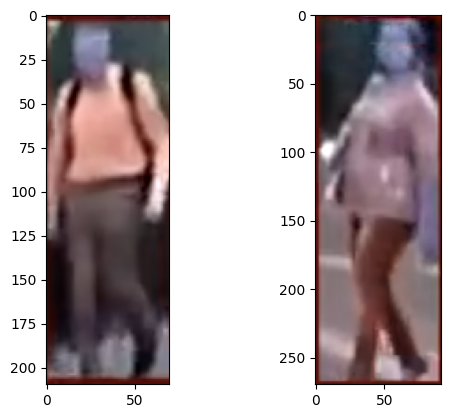

In [23]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(cv2.imread("man.png"))
ax[1].imshow(cv2.imread("woman.png"))